# ARIMA Models

While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data.

## Unit root tests
- Kwiatkowski-Phillips-Schmidt-Shin (KPSS) 
    - In this test, the null hypothesis is that the data are stationary, and we look for evidence that the null hypothesis is false.
- unitroot_nsdiffs()
    - No seasonal differences are suggested if $F_S<0.64$

## Example: Egyptian exports

In [1]:
# time series modeling
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import STL
from scipy.stats import linregress

# np and pandas
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
# ggplot utilities
from plotnine import (ggplot, geom_line, xlab, ylab, ggtitle, aes, theme, xlim, ylim,
                     geom_density, geom_histogram, after_stat, geom_ribbon, geom_smooth,
                      facet_wrap,  geom_point, scale_color_manual, scale_alpha_manual)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import shapiro, jarque_bera

# loading ts data
from tsdata.raw import available_data, load_data

# set style of plots
plt.style.use('Solarize_Light2')

Text(0.5, 1.0, 'Egypt exports as % of GDP')

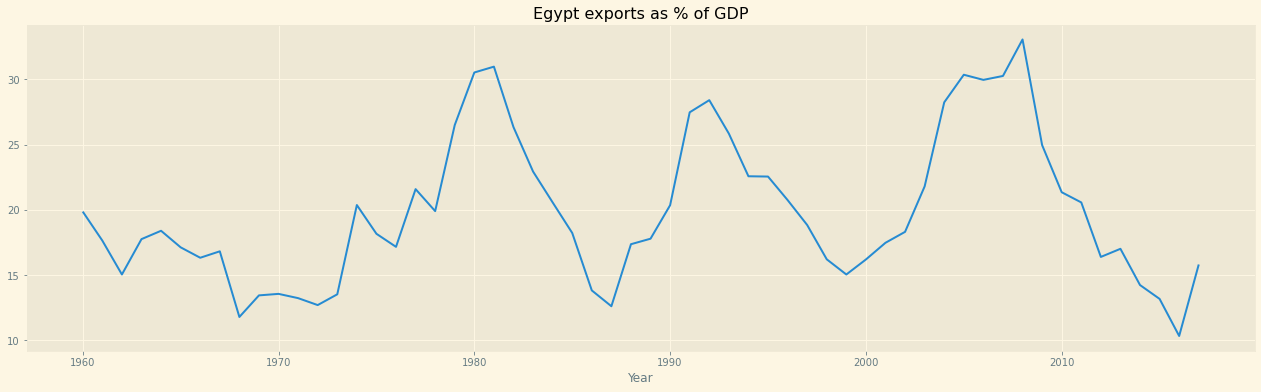

In [143]:
global_economy_df = (load_data("global_economy")
 .assign(gdp_per_capita = lambda df: df.GDP / df.Population)
)

egypt_economy_df = global_economy_df[global_economy_df.Code == "EGY"]

egypt_economy_ts = egypt_economy_df.set_index("Year").Exports


ax = egypt_economy_ts.plot(figsize=(22, 6))

ax.set_title("Egypt exports as % of GDP")

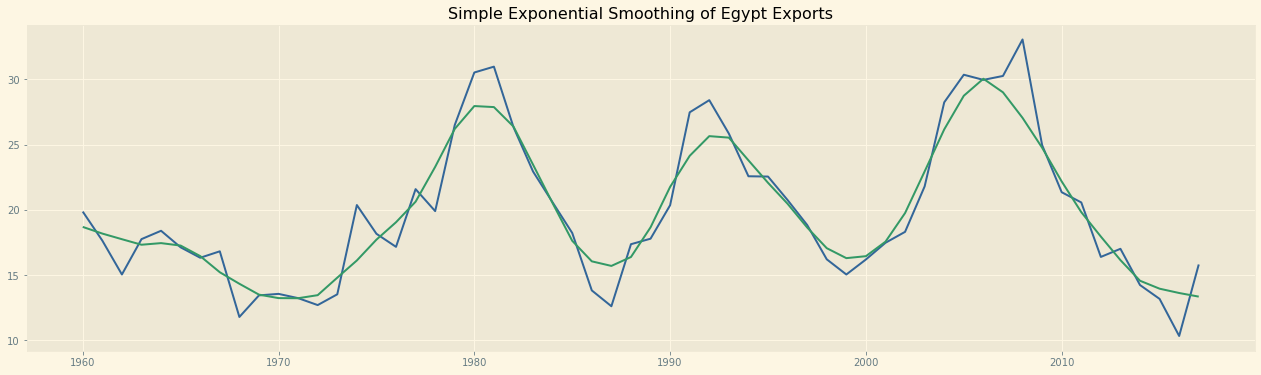

In [111]:
import numpy as np
import statsmodels.api as sm
# import lowess from sm.nonparametric
from scipy.stats import boxcox

# boxcox(egypt_economy_ts)
lowess = sm.nonparametric.lowess
z = lowess(egypt_economy_ts.values, egypt_economy_ts.index, frac=1./8)

loess_fitted_ts = pd.Series(data=z[:, 1], index=z[:, 0])

fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(6)

ax.set_title("Simple Exponential Smoothing of Egypt Exports")
# ax.plot(egypt_economy_ts, color="#336699")
ax.plot(egypt_economy_ts, color="#336699")


# loess_fitted_ts.plot()
# loess_fitted_ts
ax.plot(loess_fitted_ts, color="#339966")

JB pvalue is  0.025575933253523364
Shapiro pvalue is  0.07691889256238937


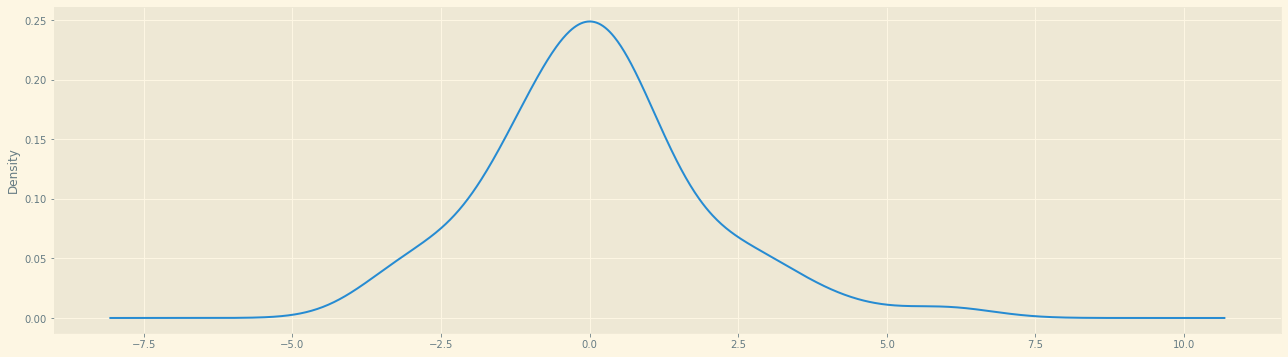

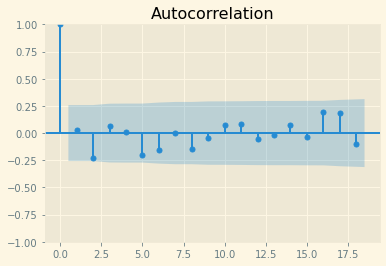

In [148]:
residuals = egypt_economy_ts - loess_fitted_ts

# residuals.plot(figsize=(22, 6))
residuals.plot.density(figsize=(22, 6))

plot_acf(residuals)
jb_stat, jb_pvalue = jarque_bera(residuals)
shapiro_stat, shapiro_pvalue = shapiro(residuals)

print("JB pvalue is ", jb_pvalue)
print("Shapiro pvalue is ", shapiro_pvalue)

In [141]:
from scipy.stats import kstest, laplace
laplace.cdf

kstest(residuals, laplace.cdf)
# residuals.shape
# (rvs, cdf, args=(), N=20, alternative='two-sided', mode='auto')[source]¶

KstestResult(statistic=0.0936261979703907, pvalue=0.654776819724721)

In [142]:
acorr_ljungbox(residuals, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,9.702383,0.466981,8.599996,0.570439


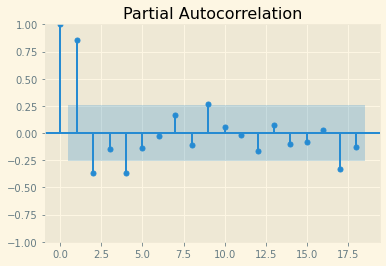

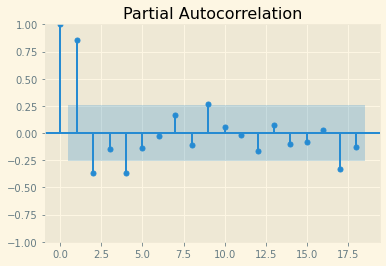

In [202]:
plot_pacf(egypt_economy_ts)

In [233]:
fitted_arima_model = ARIMA(endog=egypt_economy_ts, order=(1, 0, 2)).fit()

fitted_arima_model.summary()

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Exports   No. Observations:                   58
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -144.947
Date:                Sat, 12 Mar 2022   AIC                            299.893
Time:                        17:40:01   BIC                            310.195
Sample:                             0   HQIC                           303.906
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.7749      2.145      9.218      0.000      15.570      23.979
ar.L1          0.7217      0.167      4.312      0.000       0.394       1.050
ma.L1          0.3287      0.265      1.238      0.216      -0.192       0.849
ma.L2          0.0742      0.235      0.316      0.752      -0.386       0.534
sigma2         8.4766      1.730      4.899      0.000       5.086      11.868
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 2.02
Prob(Q):                              0.82   Prob(JB):                         0.36
Heteroskedasticity (H):               1.43   Skew:                             0.46
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ShapiroResult(statistic=0.9688122272491455, pvalue=0.14069423079490662)

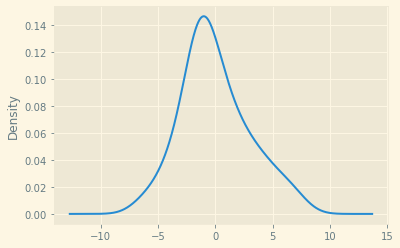

In [167]:
residuals_2 = egypt_economy_ts - fitted_arima_model.fittedvalues

residuals_2.plot.density()

shapiro(residuals_2)

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.


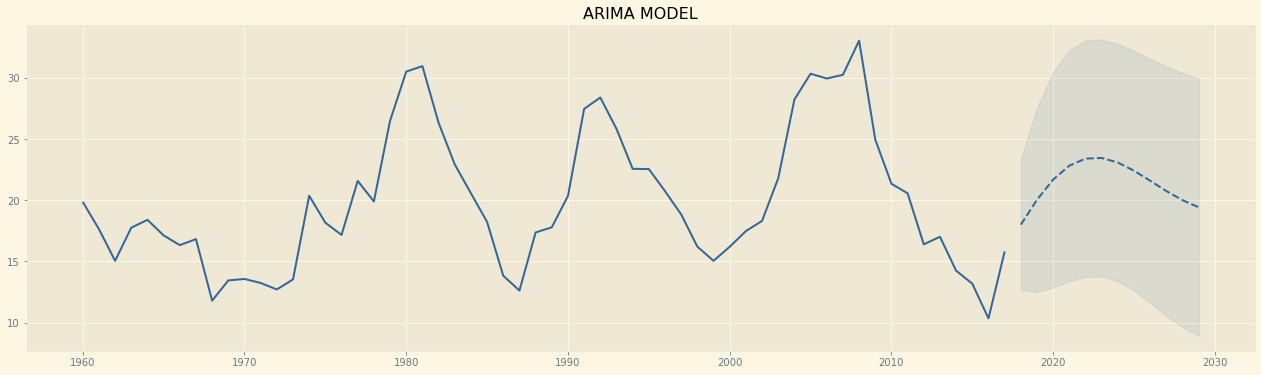

In [199]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

FORECAST_H = 12
N = egypt_economy_ts.shape[0]
last_date = egypt_economy_ts.index.max()
forecast_dates = [last_date + i for i in range(1, FORECAST_H + 1)]

model = ARIMA(egypt_economy_ts, order=(2, 0, 1))
fit = model.fit();

# one way of forecasting is using the forecast function
forecast_df = fit.get_forecast(12).summary_frame()

# plot results
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(6)

# plot the time series
ax.plot(egypt_economy_ts, color="#336699")
ax.set_title("ARIMA MODEL")

ax.plot(forecast_dates, forecast_df['mean'], '--', color="#336699")
ax.fill_between(forecast_dates, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color="#336699", alpha=0.1)
# forecasted

Partial correlation plots remove the effect of intervening correlations.

ARIMA(0,0,0)(0,0,1) will show
- a spike at lag 12 in the ACF but no other significant spikes;
- exponential decay in the seasonal lags of the PACF (i.e., at lags 12, 24, 36, …).

Similarly, an $ARIMA(0,0,0)(1,0,0)_12$ model will show:

exponential decay in the seasonal lags of the ACF;
a single significant spike at lag 12 in the PACF.

## Example: Monthly US leisure and hospitality employment

Text(0, 0.5, 'Number of people (millions)')

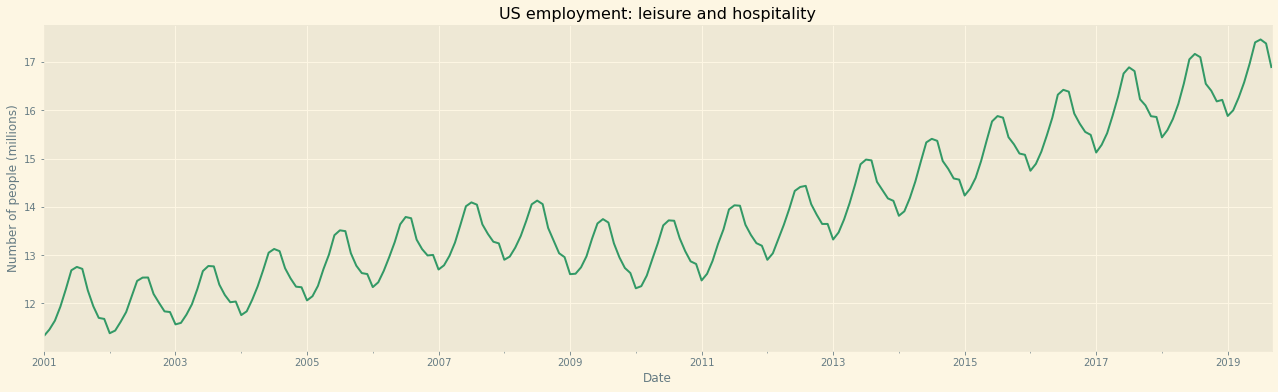

In [207]:
us_employment_df = load_data("us_employment").assign(
    Date=lambda df: pd.to_datetime(df.Month, format="%Y %b")
).assign(
    Year=lambda df: df.Date.dt.year,
    Month=lambda df: df.Date.dt.month
).set_index("Date")

is_leisure = us_employment_df.Title == "Leisure and Hospitality"
is_after_2000 = us_employment_df.Year > 2000

us_leisure_df = us_employment_df[is_leisure & is_after_2000]

leisure_ts = us_leisure_df.Employed / 1000
ax = leisure_ts.plot(figsize=(22, 6), color="#339966")
ax.set_title("US employment: leisure and hospitality")

ax.set_ylabel("Number of people (millions)")

The data are clearly non-stationary, with strong seasonality and a nonlinear trend, so we will first take a seasonal difference. The seasonally differenced data are shown in Figure 9.19.

<AxesSubplot:xlabel='Date'>

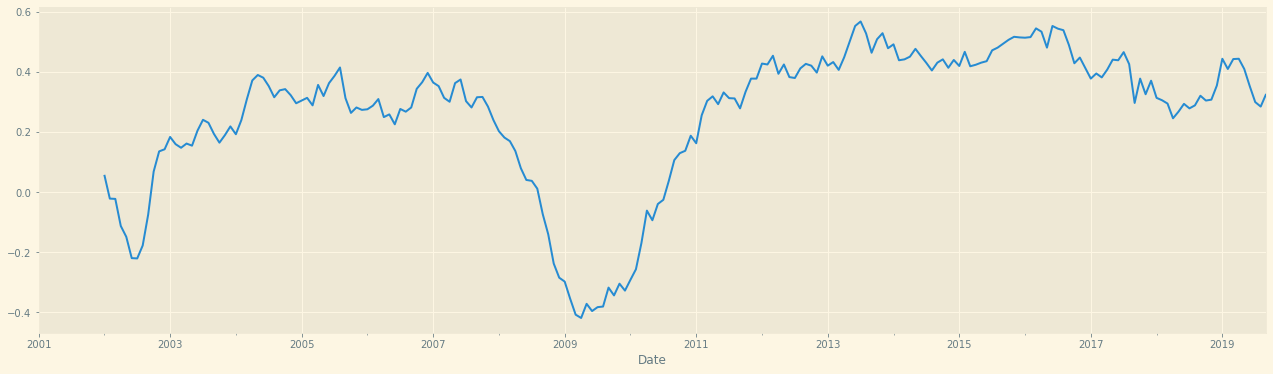

In [218]:
leisure_seasonally_differenced = leisure_ts.diff(periods=12)
leisure_seasonally_differenced.plot(figsize=(22, 6))

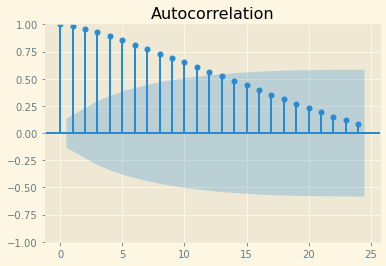

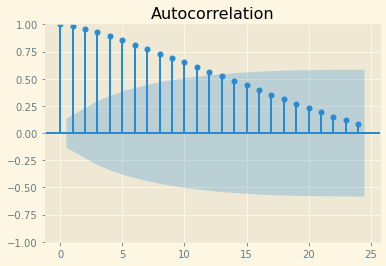

In [222]:
plot_acf(leisure_seasonally_differenced.dropna()).show()
# leisure_seasonally_differenced.na

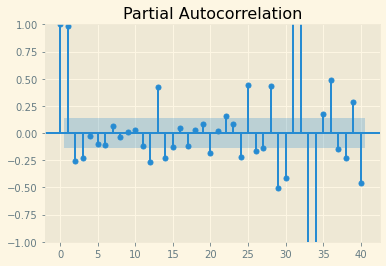

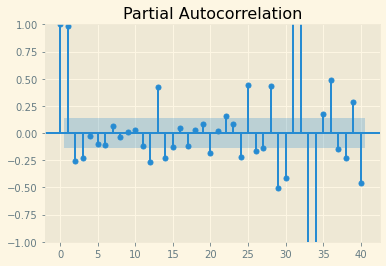

In [223]:
plot_pacf(leisure_seasonally_differenced.dropna(), lags=40).show()

The remainder is clearly not stationary, so we we take another difference of lag(1)

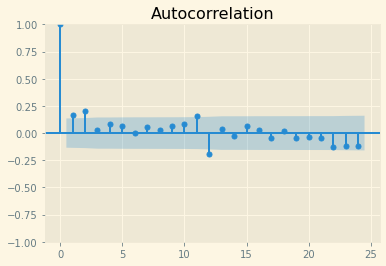

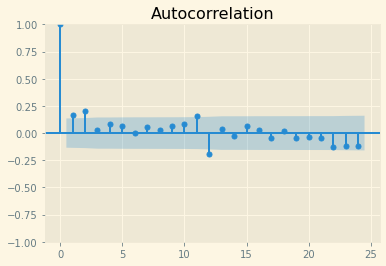

In [227]:
leisure_remainder = leisure_seasonally_differenced.diff(periods=1)
plot_acf(leisure_remainder.dropna())

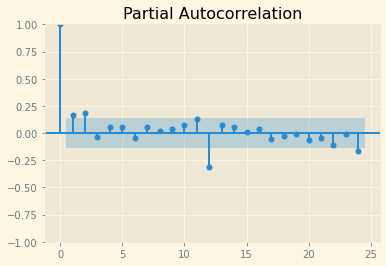

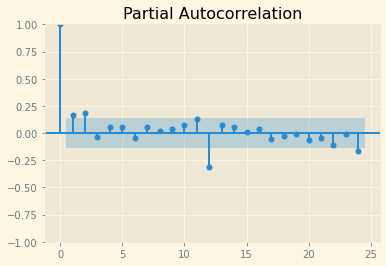

In [228]:
plot_pacf(leisure_remainder.dropna())

For the ACF plot, we can see there is a spike at lag 1 and lag 2, also there is a spike in lag 12
- MA(2) and SEASONAL MA(1)

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.


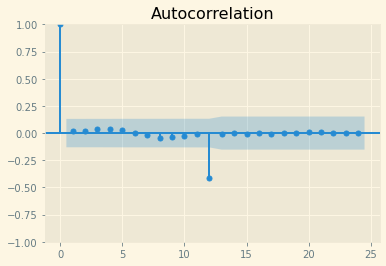

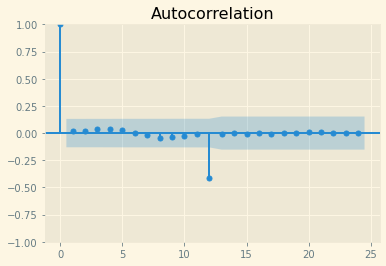

In [269]:
final = ARIMA(endog=leisure_ts, order=(2, 1, 0), seasonal_order=(1, 1, 1, 12)).fit()
plot_acf(final.resid)
# final.resid.plot()

In [282]:
from statsmodels.tsa.stattools import acf
# acf
acf(final.resid)[1:][11]

-0.41058742785656405

In [283]:
acorr_ljungbox(final.resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,2.115243,0.995378,2.041154,0.996015


The pvalue is almost 1, we can conclude that the data is white noise.

Text(0, 0.5, 'employment (in milions)')

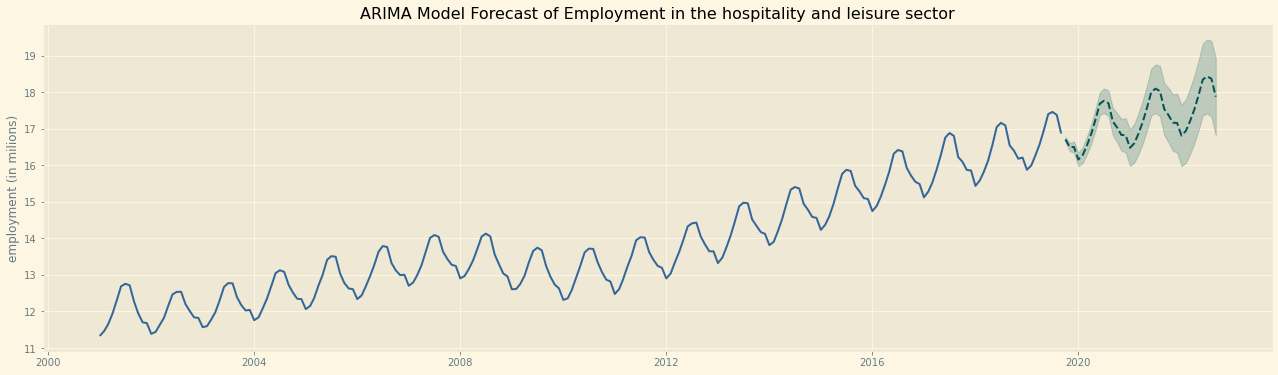

In [305]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

FORECAST_H = 36
N = leisure_ts.shape[0]
last_date = leisure_ts.index.max()

forecast_df = final.get_forecast(FORECAST_H).summary_frame()

# plot results
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(6)

# plot the time series
ax.plot(leisure_ts, color="#336699")
ax.set_title("ARIMA Model Forecast of Employment in the hospitality and leisure sector")

# plot the forecasts for the future 12 periods
ax.plot(forecast_df.index, forecast_df["mean"], "--", color="#005555")
ax.fill_between(forecast_df.index, forecast_df["mean_ci_lower"], forecast_df["mean_ci_upper"], alpha=0.2, color="#005555")

ax.set_ylabel("employment (in milions)")

## Example: Corticosteroid drug sales in Australia

For our second example, we will try to forecast monthly corticosteroid drug sales in Australia. These are known as H02 drugs under the Anatomical Therapeutic Chemical classification scheme.


Text(0.5, 1.0, 'Corticosteroid sales')

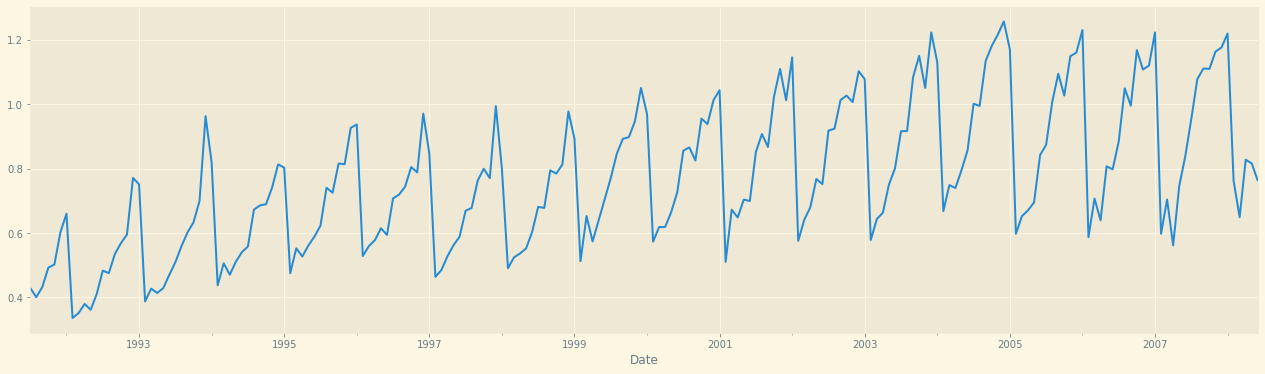

In [326]:


pbs_df = load_data("PBS").assign(
    Date=lambda df: pd.to_datetime(df.Month, format="%Y %b")
).assign(
    Year=lambda df: df.Date.dt.year,
    Month=lambda df: df.Date.dt.month
)# .set_index("Date")

h02_df = pbs_df[pbs_df.ATC2 == "H02"]



cortico_sales_ts = h02_df.groupby("Date").sum().Cost / 1e6
cortico_sales_ts.plot(figsize=(22, 6))

ax.set_title("Corticosteroid sales")

We can see that the data is not homoscedastic. We should transform it using some power transformation.

Text(0.5, 1.0, 'Logarithm transformation Corticosteroid sales')

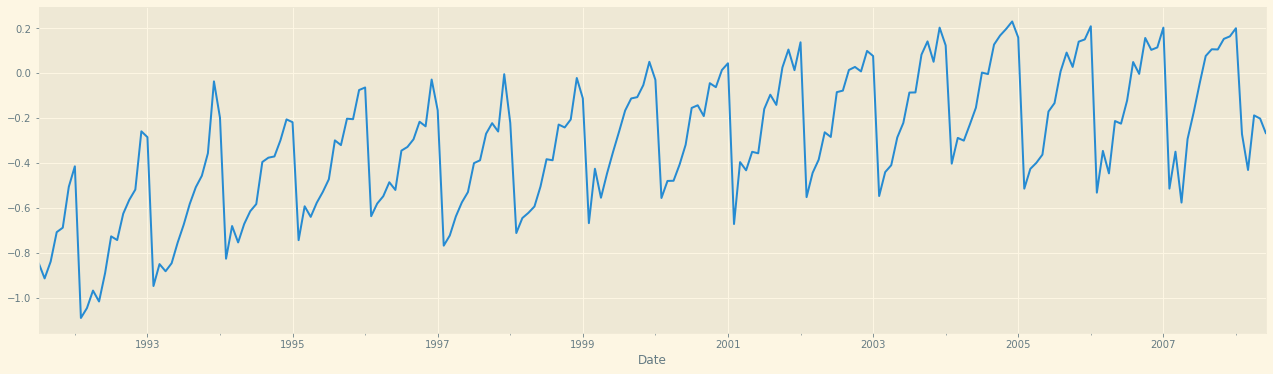

In [327]:
cortico_sales_log_ts = np.log(cortico_sales_ts)
cortico_sales_log_ts.plot(figsize=(22, 6))

ax.set_title("Logarithm transformation Corticosteroid sales")

<AxesSubplot:xlabel='Date'>

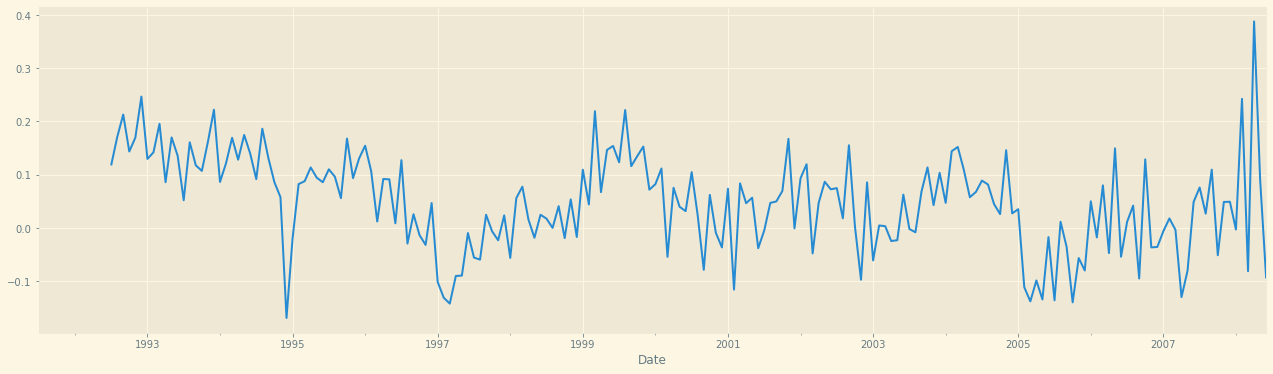

In [337]:
cortico_sales_log_diffed_ts = cortico_sales_log_ts.diff(periods=12)
cortico_sales_log_diffed_ts.plot(figsize=(22, 6))

# np.log().plot(figsize=(22, 6))
# ax.set_title("Logarithm transformation on Corticosteroid sales")

/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_2478/792587344.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


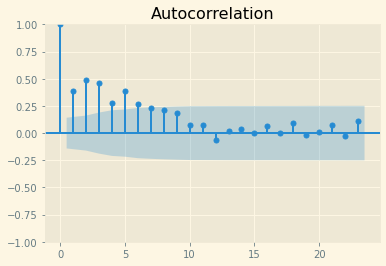

In [340]:
cortico_acf_plot = plot_acf(cortico_sales_log_diffed_ts.dropna())
cortico_acf_plot.show()

/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_2478/266439685.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


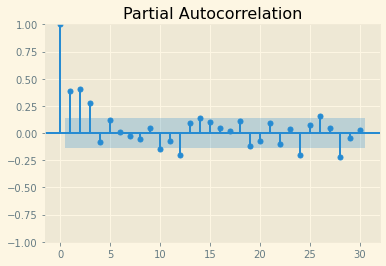

In [342]:
cortico_pacf_plot = plot_pacf(cortico_sales_log_diffed_ts.dropna(), lags=30)
cortico_pacf_plot.show()

- In the PACF plot we can see a spike at 12 and 24. This would indicate a seasonal AR component of order 2.
- There are three significant spikes in the PACF, suggesting a possible AR(3) term.


In [423]:
arima_cortico_fit = ARIMA(cortico_sales_log_ts, order=(3, 1, 1), seasonal_order=(2, 1, 0, 12)).fit()
model_orders = [
    ((3, 1, 1), (2, 1, 0, 12)),
    ((3, 0, 0), (2, 1, 0, 12)),
    ((3, 0, 0), (3, 1, 0, 12)),
    ((3, 0, 1), (0, 1, 2, 12))
]

def train_models(ts, model_orders):
    return [ARIMA(ts, None, *orders).fit() for orders in model_orders]

fitted = train_models(cortico_sales_log_ts, model_orders)

np.array([fit.aic for fit in fitted])

# arima_cortico_fit.aic

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS

array([-469.27429827, -475.57743949, -483.73843839, -486.0845277 ])

In [355]:
# ((3, 0, 1), (0, 1, 2, 12)) seems to be the best model
final_arima = ARIMA(cortico_sales_log_ts, order=(3, 0, 1), seasonal_order=(0, 1, 2, 12)).fit()

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.


Date
1991-07-01   -0.844447
1991-08-01   -0.914028
1991-09-01   -0.838962
1991-10-01   -0.708173
1991-11-01   -0.688420
                ...   
2008-02-01    0.191219
2008-03-01   -0.133474
2008-04-01    0.179625
2008-05-01   -0.031140
2008-06-01   -0.166977
Length: 204, dtype: float64

<AxesSubplot:xlabel='Date'>

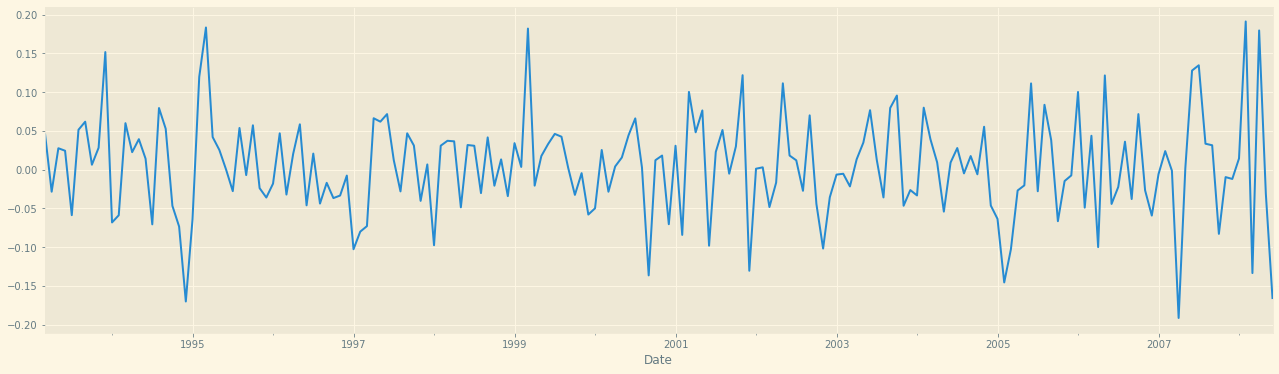

In [361]:
final_arima.resid[20:].plot(figsize=(22, 6))

<AxesSubplot:ylabel='Density'>

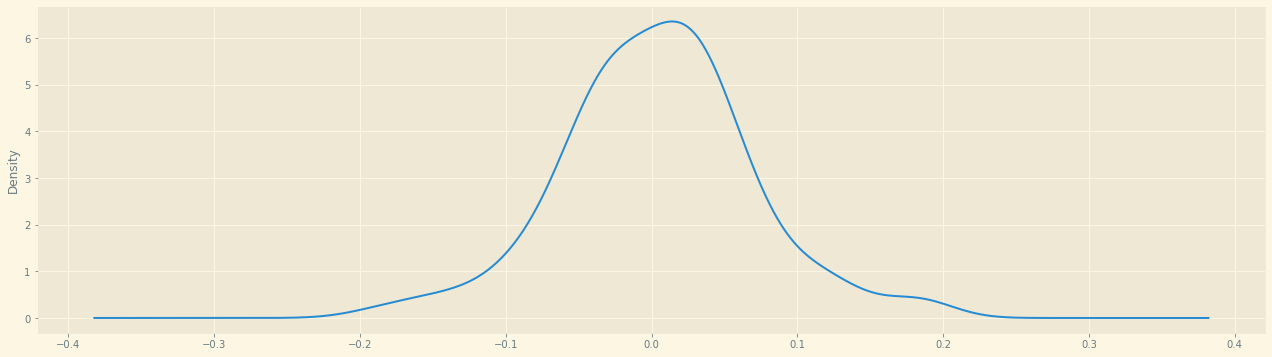

In [363]:
final_arima.resid[20:].plot.density(figsize=(22, 6))

In [364]:
resids = final_arima.resid[20:]

shapiro(resids)

ShapiroResult(statistic=0.985315203666687, pvalue=0.05146065354347229)

/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_2478/3077487579.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


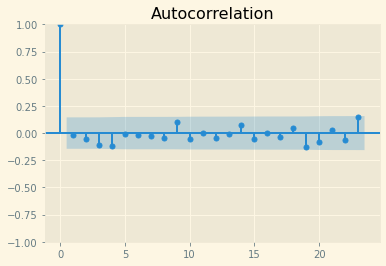

In [369]:
plot_acf(resids).show()

In [372]:
acorr_ljungbox(resids, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,8.972333,0.534731,8.616578,0.568836


Text(0, 0.5, 'Sales')

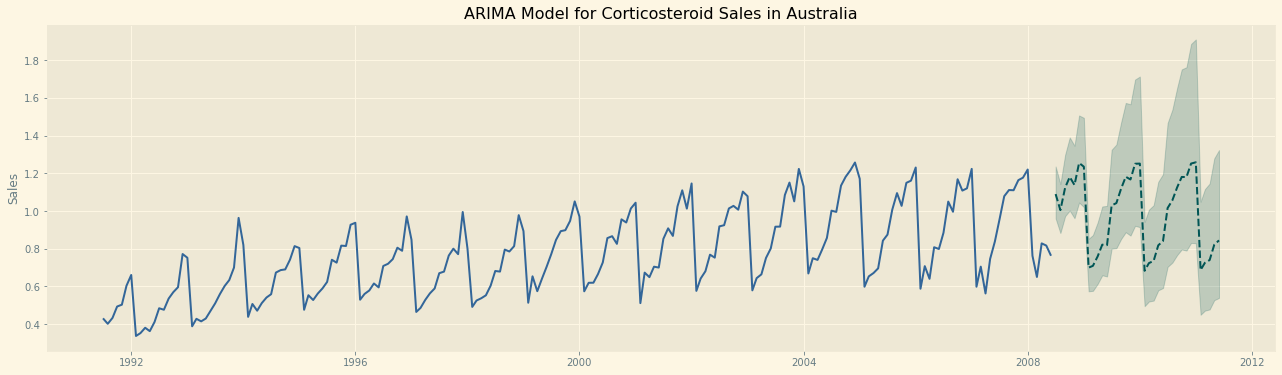

In [376]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

FORECAST_H = 36
N = cortico_sales_ts.shape[0]
last_date = cortico_sales_ts.index.max()

forecast_df = final_arima.get_forecast(FORECAST_H).summary_frame()

# plot results
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(6)

# plot the time series
ax.plot(cortico_sales_ts, color="#336699")
ax.set_title("ARIMA Model for Corticosteroid Sales in Australia")

# plot the forecasts for the future 12 periods
ax.plot(forecast_df.index, np.exp(forecast_df["mean"]), "--", color="#005555")
ax.fill_between(forecast_df.index, np.exp(forecast_df["mean_ci_lower"]), np.exp(forecast_df["mean_ci_upper"]), alpha=0.2, color="#005555")

ax.set_ylabel("Sales")

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# split the data into train and test sets
ts_split = TimeSeriesSplit(n_splits=2, test_size=24)
train_ts, test_ts = [cortico_sales_log_ts[i] for i in next(ts_split.split(cortico_sales_ts))]

# train the models on the train set
train_set_models = train_models(train_ts, model_orders)

In [432]:
orders_from_book = [
    ((3, 0, 1), (1, 1, 1, 12)),
    ((3, 0, 1), (0, 1, 2, 12)),
    ((2, 1, 1), (0, 1, 1, 12)),
    ((2, 1, 2), (0, 1, 1, 12)),
    ((2, 1, 4), (0, 1, 1, 12)),
    ((2, 1, 3), (0, 1, 1, 12)),
    ((3, 0, 1), (0, 1, 1, 12)),
    ((3, 0, 2), (0, 1, 1, 12)),
    ((2, 1, 0), (0, 1, 1, 12)),
    ((3, 0, 1), (0, 1, 3, 12)),
    ((3, 0, 3), (0, 1, 1, 12)),
    ((3, 0, 2), (2, 1, 0, 12)),
    ((3, 0, 1), (2, 1, 0, 12)),
    ((2, 1, 0), (1, 1, 0, 12)),
    ((3, 0, 1), (1, 1, 0, 12)),
    ((3, 0, 0), (2, 1, 0, 12))
]

fitted_book = train_models(train_ts, orders_from_book)


# models_from_book = 

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

In [430]:
actual = np.exp(test_ts)
rmses = [mean_squared_error(actual, np.exp(m.forecast(24)), squared=True) for m in fitted_book]


[0.008003938502241553,
 0.009711341040834381,
 0.011494951882399058,
 0.012212090869167747,
 0.012044386703345011,
 0.01132564728194138,
 0.007544285369001954,
 0.008267365174662825,
 0.011760846806029387,
 0.010010520688105548,
 0.009933381953138117,
 0.007881158253256559,
 0.00870027374167552,
 0.015323457161323406,
 0.00797408011697396,
 0.009610179804354569]

In [434]:
orders_from_book[np.argmin(rmses)]

((3, 0, 1), (0, 1, 1, 12))